In [1]:
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
from scipy import io
import numpy as np
import torch
from cuda import cuda
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


In [2]:
testdir = r"C:\Users\XGAMER\test_32x32"
test_data = scipy.io.loadmat(testdir)
test_labels = test_data['y']
test_images = test_data['X']

print(test_images.shape)
print(test_labels.shape)

print(test_labels[0:3])
le = LabelEncoder()
test_labels = le.fit_transform(test_labels.ravel()) 
test_labels = test_labels + 1  #Dataset starts from 1 and Label Encoder starts from 0 class
print(test_labels[0:3])        #transformed

print(test_images.shape)
print(test_labels.shape)


(32, 32, 3, 26032)
(26032, 1)
[[5]
 [2]
 [1]]
[5 2 1]
(32, 32, 3, 26032)
(26032,)


In [3]:
traindir = r"C:\Users\XGAMER\train_32x32"
train_data = scipy.io.loadmat(traindir)
train_labels = train_data['y']
train_images = train_data['X']

print(train_images.shape)
print(train_labels.shape)

train_labels = le.fit_transform(train_labels.ravel())
train_labels = train_labels + 1

print(train_images.shape)
print(train_labels.shape)

(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 73257)
(73257,)


In [4]:
train_imagesKNN, train_labelsKNN, test_imagesKNN, test_labelsKNN= train_images, train_labels, test_images, test_labels # (n, 32, 32 ,RGB)

train_imagesKNN = np.transpose(train_imagesKNN, (3,0,1,2))
print(train_imagesKNN.shape)

test_imagesKNN = np.transpose(test_imagesKNN, (3,0,1,2))
print(test_imagesKNN.shape)

train_imagesKNN = np.reshape(train_imagesKNN, (73257,3072)) # From 4D to 2D
test_imagesKNN = np.reshape(test_imagesKNN, (26032,3072))

test_imagesKNNc = test_imagesKNN[0:1000,:]
train_imagesKNNc = train_imagesKNN[0:1000, :]  
test_labelsKNNc = test_labelsKNN[0:1000]
train_labelsKNNc = train_labelsKNN[0:1000]

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(train_imagesKNNc, train_labelsKNNc)
acc = knn.score(train_imagesKNNc,train_labelsKNNc)


(73257, 32, 32, 3)
(26032, 32, 32, 3)
pixel accuracy: 100.00%


In [5]:
pred = knn.predict(test_imagesKNNc)
accuracy = accuracy_score(test_labelsKNNc, pred)
print("accuracy: {:.2f}%".format(accuracy * 100))

accuracy: 23.50%


In [6]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def images3d(data):
    images = [] #create empty list 
    for i in range(0, data.shape[3]): #73257 gia train images, 26032 gia test images
        images.append(rgb2gray(data[:, :, :, i])) #to append einai gia lists
    return np.asarray(images) #metatroph list se numpy array

    
train_imagesNN, test_imagesNN = train_images / 255, test_images / 255 
train_labelsNN, test_labelsNN = train_labels, test_labels


print(train_imagesNN.shape ,'Train images')
print(test_imagesNN.shape, 'Test images')
print(train_labelsNN.shape, 'train labels')
print(test_labelsNN.shape, 'test labels')

train_imagesNN=images3d(train_imagesNN)
test_imagesNN=images3d(test_imagesNN)

print('----after format------')
print(train_imagesNN.shape, 'Train images')
print(test_imagesNN.shape, 'Test images')
print(train_labelsNN.shape, 'Train labels')
print(test_labelsNN.shape, 'Test labels')

model = keras.models.Sequential([
keras.layers.Flatten(input_shape = [32, 32]), 
keras.layers.Dense(500, activation = 'relu' ),
keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(200, activation = 'relu' ),
keras.layers.Dense(11, activation = 'softmax' )])

model.summary()

(32, 32, 3, 73257) Train images
(32, 32, 3, 26032) Test images
(73257,) train labels
(26032,) test labels
----after format------
(73257, 32, 32) Train images
(26032, 32, 32) Test images
(73257,) Train labels
(26032,) Test labels
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 500)               512500    
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                         

In [7]:
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(train_imagesNN,train_labelsNN,epochs = 10, validation_data = (test_imagesNN, test_labelsNN), batch_size=100)

Epoch 1/10
733/733 [==============================] - 6s 7ms/step - loss: 1.9288 - accuracy: 0.3136 - val_loss: 1.5748 - val_accuracy: 0.4699
Epoch 2/10
733/733 [==============================] - 5s 7ms/step - loss: 1.2700 - accuracy: 0.5817 - val_loss: 1.2103 - val_accuracy: 0.6175
Epoch 3/10
733/733 [==============================] - 5s 7ms/step - loss: 1.0481 - accuracy: 0.6672 - val_loss: 1.0822 - val_accuracy: 0.6629
Epoch 4/10
733/733 [==============================] - 5s 7ms/step - loss: 0.9510 - accuracy: 0.6985 - val_loss: 1.0033 - val_accuracy: 0.6829
Epoch 5/10
733/733 [==============================] - 5s 7ms/step - loss: 0.8669 - accuracy: 0.7264 - val_loss: 1.0048 - val_accuracy: 0.6878
Epoch 6/10
733/733 [==============================] - 5s 7ms/step - loss: 0.8119 - accuracy: 0.7422 - val_loss: 0.9262 - val_accuracy: 0.7158
Epoch 7/10
733/733 [==============================] - 5s 7ms/step - loss: 0.7605 - accuracy: 0.7582 - val_loss: 0.8821 - val_accuracy: 0.7261
Epoch 

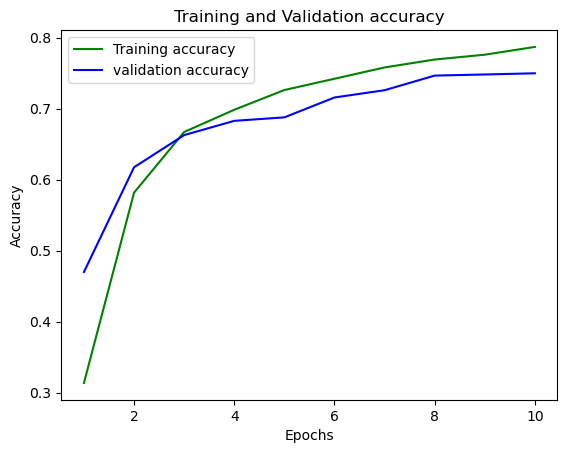

In [8]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

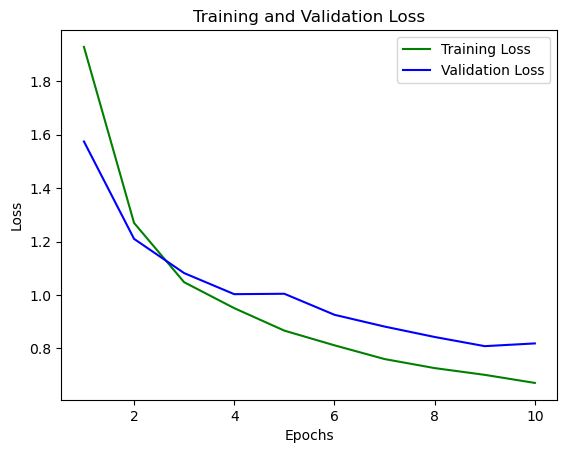

In [9]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()